In [3]:
# 필수 데이터 분석 및 시각화, 백테스팅 라이브러리 설치
%pip install pandas numpy plotly bt requests nbformat python-dotenv

Note: you may need to restart the kernel to use updated packages.


## 📌 Step 0. ETF NAV 데이터 불러오기 (준비 단계)

In [4]:
from data_manager import load_or_download_nav  # ← 이전 강의에서 만든 모듈

code_kospi200 = "069500"
code_krbond   = "153130"

df_KOSPI200 = load_or_download_nav(code_kospi200, start="2010-01-01")
df_KRbond   = load_or_download_nav(code_krbond,   start="2012-01-01")

df_KOSPI200.head(), df_KRbond.head()

ImportError: cannot import name 'find_code_by_name' from 'kis.mst' (/Users/ulift/workspace/py-etf-mango/kis/mst.py)

## 📌 Step 1. Raw Price 시각화 — 왜 가격 비교가 어렵나?

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_KOSPI200.index, y=df_KOSPI200["Close"], name="KODEX 200"))
fig.add_trace(go.Scatter(x=df_KRbond.index, y=df_KRbond["Close"], name="KODEX 단기채권"))

fig.update_layout(
    title="Raw Price 비교 — ETF 가격대가 달라 직접 비교가 어려움",
    width=700,
    height=400
)
fig.show()


In [ ]:
# 1) 이름으로 KIS 6자리 코드 찾기 (equity_master 기반)
code_kospi200 = "069500"
code_krbond   = 153130

# 2) NAV 로드 (없으면 KIS에서 다운로드 + 캐시)
df_KOSPI200 = load_or_download_nav(code_kospi200, start="2010-01-01")
df_KRbond   = load_or_download_nav(code_krbond,   start="2012-01-01")

print("\n[HEAD] KOSPI200")
print(df_KOSPI200[["Close"]].head())
print("\n[HEAD] 단기채")
print(df_KRbond[["Close"]].head())

NameError: name 'load_or_download_nav' is not defined

## 📌 Step 2. 정규화(Normalization) 후 공정한 비교

In [ ]:
# Step 2. 정규화(Normalization) 후 공정한 비교
import pandas as pd

# Step 2-1. 기준 날짜를 맞춤 (늦게 상장된 ETF 기준)
start = max(df_KOSPI200.index.min(), df_KRbond.index.min())
s1 = df_KOSPI200["Close"][df_KOSPI200.index >= start]
s2 = df_KRbond["Close"][df_KRbond.index >= start]

# Step 2-2. 공통 영업일만 사용
common = s1.index.intersection(s2.index)
s1, s2 = s1.loc[common], s2.loc[common]

# Step 2-3. 정규화 (start = 100)
df_norm = pd.DataFrame({
    "Date": common,
    "KODEX 200": s1 / s1.iloc[0] * 100,
    "KODEX 단기채권": s2 / s2.iloc[0] * 100,
})

import plotly.express as px
fig = px.line(
    df_norm, x="Date", y=["KODEX 200", "KODEX 단기채권"],
    title="정규화된 수익률 비교 (둘 다 시작점 = 100)"
)
fig.show()


## 📌 Step 3. bt 라이브러리로 수익률·위험지표 분석

In [ ]:
import bt
import matplotlib.pyplot as plt

data = pd.DataFrame({
    "069500": s1,
    "153130": s2
})

strategy = bt.Strategy("Buy & Hold", [
    bt.algos.RunOnce(),
    bt.algos.SelectAll(),
    bt.algos.WeighEqually(),
    bt.algos.Rebalance()
])

t1 = bt.Backtest(strategy, data[["069500"]], name="069500")
t2 = bt.Backtest(strategy, data[["153130"]], name="153130")

res = bt.run(t1, t2)
res.set_riskfree_rate(0.025)
res.display()


100%|██████████| 2/2 [00:00<00:00, 12.97it/s]


Stat                 069500      153130
-------------------  ----------  ----------
Start                2012-06-26  2012-06-26
End                  2025-11-26  2025-11-26
Risk-free rate       2.50%       2.50%

Total Return         192.89%     28.55%
Daily Sharpe         0.72        1.06
Daily Sortino        1.49        17.58
CAGR                 8.34%       1.89%
Max Drawdown         -34.07%     -0.13%
Calmar Ratio         0.24        14.04

MTD                  -3.62%      0.11%
3m                   30.19%      0.42%
6m                   69.21%      2.46%
YTD                  69.21%      2.46%
1Y                   69.21%      2.46%
3Y (ann.)            25.48%      3.02%
5Y (ann.)            7.92%       2.40%
10Y (ann.)           11.61%      1.75%
Since Incep. (ann.)  8.34%       1.89%

Daily Sharpe         0.72        1.06
Daily Sortino        1.49        17.58
Daily Mean (ann.)    23.24%      4.54%
Daily Vol (ann.)     28.82%      1.96%
Daily Skew           6.62        12.65
Daily 

### 누적 수익률 그래프

In [ ]:
plt.rcParams['font.family'] = 'Nanum Gothic'

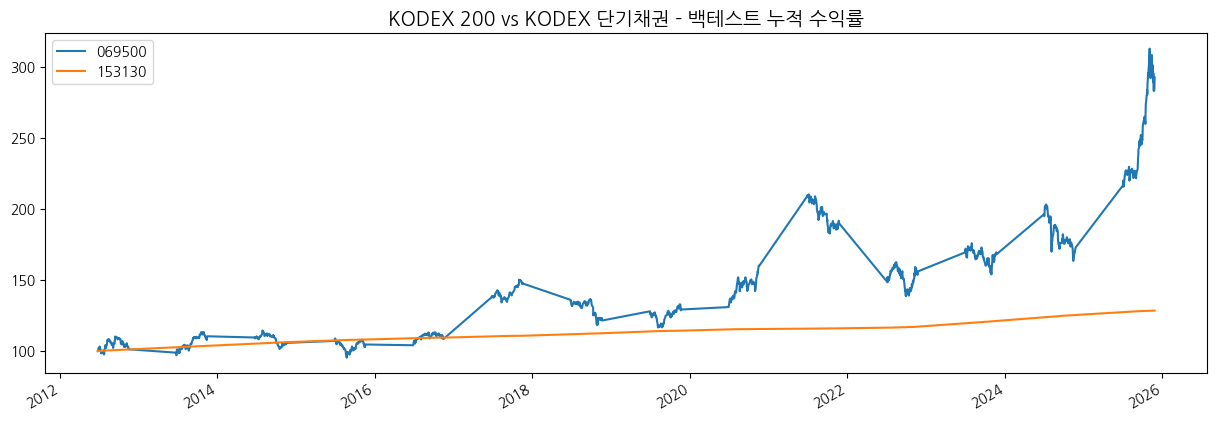

In [ ]:
ax = res.plot()
ax.set_title("KODEX 200 vs KODEX 단기채권 - 백테스트 누적 수익률", fontsize=14)
plt.show()
